In [5]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [7]:
device = get_default_device()
device

device(type='cpu')

In [2]:
# Define the U-Net architecture for binary segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder (upsampling path)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv1 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv5 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.dec_upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv7 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

          # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)  # 1x1 convolution for binary segmentation


    def forward(self, x):
        # Encoder (downsampling path)
        enc1 = nn.ReLU()(self.enc_conv1(x))
        enc2 = nn.ReLU()(self.enc_conv2(enc1))
        enc2_pool = self.enc_pool1(enc2)

        enc3 = nn.ReLU()(self.enc_conv3(enc2_pool))
        enc4 = nn.ReLU()(self.enc_conv4(enc3))
        enc4_pool = self.enc_pool2(enc4)

        enc5 = nn.ReLU()(self.enc_conv5(enc4_pool))
        enc6 = nn.ReLU()(self.enc_conv6(enc5))
        enc6_pool = self.enc_pool3(enc6)

        enc7 = nn.ReLU()(self.enc_conv7(enc6_pool))
        enc8 = nn.ReLU()(self.enc_conv8(enc7))
        enc8_pool = self.enc_pool4(enc8)

        # Bottleneck
        bottleneck = nn.ReLU()(self.bottleneck_conv1(enc8_pool))
        bottleneck = nn.ReLU()(self.bottleneck_conv2(bottleneck))

        # Decoder (upsampling path)
        dec1 = self.dec_upsample1(bottleneck)
        dec1 = torch.cat([dec1, enc8], dim=1)
        dec1 = nn.ReLU()(self.dec_conv1(dec1))
        dec1 = nn.ReLU()(self.dec_conv2(dec1))

        dec2 = self.dec_upsample2(dec1)
        dec2 = torch.cat([dec2, enc6], dim=1)
        dec2 = nn.ReLU()(self.dec_conv3(dec2))
        dec2 = nn.ReLU()(self.dec_conv4(dec2))

        dec3 = self.dec_upsample3(dec2)
        dec3 = torch.cat([dec3, enc4], dim=1)
        dec3 = nn.ReLU()(self.dec_conv5(dec3))
        dec3 = nn.ReLU()(self.dec_conv6(dec3))

        dec4 = self.dec_upsample4(dec3)
        dec4 = torch.cat([dec4, enc2], dim=1)
        dec4 = nn.ReLU()(self.dec_conv7(dec4))
        dec4 = nn.ReLU()(self.dec_conv8(dec4))

        # Output
        output = self.output_conv(dec4)
        return output   
    
    # Create an instance of the FCN model
model = UNet()

In [3]:
# Define criterion and optimizer
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
transform = transforms.Compose([
    # transforms.Resize((256, 256)),  # Resize the image to a specific size
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0,0,0],  # Example normalization values for RGB images
    #                         std=[1,1,1])
    # transforms.Normalize(mean=[0.8463, 0.8872, 0.9100],  # Simple
    #                         std=[0.1631, 0.0693, 0.0253])
    # transforms.Normalize(mean=[0.4537, 0.4567, 0.3631],  # Photorealistic
    #                         std=[0.2713, 0.2724, 0.3004])
    transforms.Normalize(mean=[0.8451, 0.8839, 0.9087],  # Simple, small angle
                            std=[0.1665, 0.0732, 0.0229])
])
# Mask does not need to be normalized in this way as it does not have 3 channels anymore
transform_mask = transforms.Compose([
    # transforms.Resize((256, 256)),  # Resize the image to a specific size
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Example normalization values for RGB images
    #                         std=[0.229, 0.224, 0.225])
])

In [12]:
# In this example, the CustomDataset takes in two lists of file paths: image_list and mask_list, representing the paths to the images and their corresponding masks, 
# respectively. It also takes in an optional transform argument to apply any necessary transformations to the images and masks.
class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None, transform_mask=None):
        # self.image_list = image_list
        # self.mask_list = mask_list
        self.image_list = [os.path.join(image_list, f) for f in os.listdir(image_list)]
        self.mask_list = [os.path.join(mask_list, f) for f in os.listdir(mask_list)]
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        mask = Image.open(mask_path)
        mask = mask.convert('L')

        if self.transform:
            image = self.transform(image)
            # mask = self.transform_mask(mask)
        if self.transform_mask:
            # image = self.transform(image)
            mask = self.transform_mask(mask)


        return image, mask

In [13]:
# Load the 

# all_data = CustomDataset('Droplet_Train/','Droplet_Mask_Train/', transform=transform)
# train_data, val_data = torch.utils.data.random_split(all_data, [180, 20])
train_data = CustomDataset('Data/Angle_test/','Data/Angle_test_mask/', transform=transform, transform_mask=transform_mask)
val_data = CustomDataset('Data/Angle_val/','Data/Angle_mask_val/', transform=transform, transform_mask=transform_mask)



In [14]:
# Define the data loader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [10]:
# from tqdm import tqdm 
# Compute mean and std

# from tqdm import tqdm

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
# for inputs in train_data:#DataLoader(train_data, batch_size=batch_size, shuffle=True):
for i, (images, labels) in enumerate(train_loader):
    psum    += images.sum(axis        = [0, 2, 3])
    psum_sq += (images ** 2).sum(axis = [0, 2, 3])
    

# Final Calculation
# pixel count
image_size = 256
count = 942 * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.8451, 0.8839, 0.9087])
std:  tensor([0.1665, 0.0732, 0.0229])


In [16]:
num_epochs = 5

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for i, (images, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss every 10 batches
        if i % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Accumulate the loss over all batches
            val_loss += loss.item() * images.size(0)
    
    # Compute the average validation loss
    val_loss /= len(val_data)
    print(f'Epoch [{epoch+1}/{num_epochs}] , Val Loss: {val_loss:.4f}')

#Save model
torch.save(model.state_dict(), 'Unet_smallangle.pt')

Epoch [1/5], Batch [1/30], Loss: 0.1308
Epoch [1/5], Batch [2/30], Loss: 0.0728
Epoch [1/5], Batch [3/30], Loss: 34844.1094
Epoch [1/5], Batch [4/30], Loss: 0.0513
Epoch [1/5], Batch [5/30], Loss: 0.0946
Epoch [1/5], Batch [6/30], Loss: 0.1109
Epoch [1/5], Batch [7/30], Loss: 0.1178
Epoch [1/5], Batch [8/30], Loss: 0.1194
Epoch [1/5], Batch [9/30], Loss: 0.1188
Epoch [1/5], Batch [10/30], Loss: 0.1115
Epoch [1/5], Batch [11/30], Loss: 0.1024
Epoch [1/5], Batch [12/30], Loss: 0.1100
Epoch [1/5], Batch [13/30], Loss: 0.1014
Epoch [1/5], Batch [14/30], Loss: 0.0858
Epoch [1/5], Batch [15/30], Loss: 0.0623
Epoch [1/5], Batch [16/30], Loss: 0.1006
Epoch [1/5], Batch [17/30], Loss: 0.2524
Epoch [1/5], Batch [18/30], Loss: 0.0717
Epoch [1/5], Batch [19/30], Loss: 0.0892
Epoch [1/5], Batch [20/30], Loss: 0.0957
Epoch [1/5], Batch [21/30], Loss: 0.0969
Epoch [1/5], Batch [22/30], Loss: 0.0949
Epoch [1/5], Batch [23/30], Loss: 0.0917
Epoch [1/5], Batch [24/30], Loss: 0.0884
Epoch [1/5], Batch [2

KeyboardInterrupt: 

In [40]:
torch.save(model.state_dict(), 'Unet_smallangle.pt')

In [8]:
# Load model
model = UNet()
model.load_state_dict(torch.load('Unet_real.pt'))

<All keys matched successfully>

In [11]:
# Testing model on given outptut
# image_path = "Droplet_XY_val/drop_s40_v5_r0.5_str2_pos2.png"drop_s40_v5_r0.5_str5_pos11.png
image_path = "Droplet_Val_Real/drop_s40_v5_r0.5_str4_pos0_cam3.png"
# image_path = "syringe-needle-with-droplet-close-up-stuart-minzey.jpg"
image = Image.open(image_path)
image = image.convert('RGB')
image = image.resize((256,256))
img = transform(image)
img = img.unsqueeze(0)
img.size()

image_mask_path = "Droplet_Mask_Val_Real/drop_s40_v5_r0.5_str4_pos0_cam3.png"
image_mask = Image.open(image_mask_path)
image_mask = image_mask.convert('L')
img_mask = transform_mask(image_mask)
img_mask = img_mask.unsqueeze(0)
img_mask.size()

torch.Size([1, 1, 256, 256])

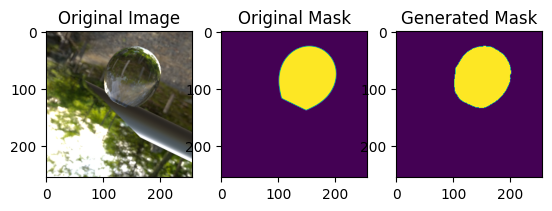

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the trained model and a test image

# Set the model to evaluation mode
model.eval()

# Perform forward pass on the test image
with torch.no_grad():
    output = model(img)  # Assuming you have the test image as a tensor

# Convert the output tensor to a numpy array and squeeze the batch and channel dimensions
output_np = output.squeeze(0).squeeze(0).cpu().numpy()

# Apply a threshold to convert the output to a binary mask
threshold = 0.5  # Adjust the threshold value as needed
mask = (output_np >= threshold).astype(np.uint8)
# Plot the original test image
plt.subplot(1, 3, 1)
plt.imshow(image.resize((256,256)))
plt.title('Original Image')
# Plot the original mask
plt.subplot(1, 3, 2)
plt.imshow(image_mask.resize((256,256)))
plt.title('Original Mask')
# Plot the generated mask
plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title('Generated Mask')

plt.show()

In [102]:
print(output)

tensor([[[[-0.0682, -0.0679, -0.0676,  ..., -0.0682, -0.0666, -0.0696],
          [-0.0676, -0.0652, -0.0653,  ..., -0.0651, -0.0659, -0.0693],
          [-0.0686, -0.0640, -0.0662,  ..., -0.0656, -0.0656, -0.0693],
          ...,
          [-0.0685, -0.0647, -0.0655,  ..., -0.0636, -0.0641, -0.0681],
          [-0.0686, -0.0646, -0.0645,  ..., -0.0631, -0.0640, -0.0664],
          [-0.0694, -0.0662, -0.0663,  ..., -0.0660, -0.0656, -0.0677]]]])
